In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
import glob
import sys


# Importing callbacks and data augmentation utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import  Adam
import scipy.io as sio

var_sampling_mask (1, 1, 320, 1) float32 <class 'numpy.ndarray'>
Sampling: 0.234375
Number of 1s: 75 (23.43750000%)
Number of 0s: 245 (76.56250000%)
Min 0.0
Max 1.0
data range 1.0
var_sampling_mask (1, 1, 320, 1) float32 <class 'numpy.ndarray'>
var_sampling_mask[0] (1, 320, 1) float32 <class 'numpy.ndarray'>


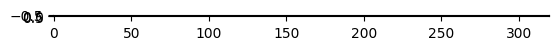

In [2]:
#hybrid_cascade/fastmri/Data/mask_4x_320_random.npy
var_sampling_mask=np.load(r"C:\Users\DU\aman_fastmri\Data\mask_4x_320_random.npy")
print("var_sampling_mask",var_sampling_mask.shape,var_sampling_mask.dtype,type(var_sampling_mask))


print("Sampling:", 1.0*var_sampling_mask.sum()/var_sampling_mask.size)
num_zeros = np.sum(var_sampling_mask[0] == 0)
num_ones = np.sum(var_sampling_mask[0] == 1)
# Print results
total_pixels = var_sampling_mask[0].size

# Calculate percentages
ones_percentage = (num_ones / total_pixels) * 100
zeros_percentage = (num_zeros / total_pixels) * 100

print(f"Number of 1s: {num_ones} ({ones_percentage:.8f}%)")
print(f"Number of 0s: {num_zeros} ({zeros_percentage:.8f}%)")
print("Min",var_sampling_mask[0].min())
print("Max",var_sampling_mask[0].max())
print("data range",var_sampling_mask[0].max()-var_sampling_mask[0].min())
print("var_sampling_mask",var_sampling_mask.shape,var_sampling_mask.dtype,type(var_sampling_mask))
print("var_sampling_mask[0]",var_sampling_mask[0].shape,var_sampling_mask[0].dtype,type(var_sampling_mask[0]))
plt.imshow(var_sampling_mask[0],cmap='gray')

In [3]:
from sklearn.metrics import mean_squared_error
import os
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
class VolumeWiseNMSE(tf.keras.callbacks.Callback):
    def __init__(self, val_files, save_best_path):
        self.val_files = val_files
        self.best_nmse = float('inf')
        self.save_best_path = save_best_path

    def on_epoch_end(self, epoch, logs=None):
        total_nmse = 0
        num_volumes = 0

        for file_path in self.val_files:
            with h5py.File(file_path, 'r') as f:
                image_under = f['image_under'][:]  # [slices, H, W, 2]
                gt = f['image_full'][:]

            pred = []
            for i in range(image_under.shape[0]):
                input_slice = np.expand_dims(image_under[i], axis=0)
                pred_slice = self.model.predict(input_slice, verbose=0)
                pred.append(pred_slice[0])
            pred = np.stack(pred)

            nmse = np.sum((np.abs(gt - pred) ** 2)) / np.sum((np.abs(gt) ** 2))
            total_nmse += nmse
            num_volumes += 1

        avg_nmse = total_nmse / num_volumes
        print(f"\nEpoch {epoch + 1} - Avg NMSE: {avg_nmse:.6f}")

        if avg_nmse < self.best_nmse:
            print(f"New best model found! Saving model with NMSE {avg_nmse:.6f}")
            self.best_nmse = avg_nmse
            self.model.save(self.save_best_path)


In [4]:
train_folder = r"D:\fastmri_singlecoil_FSSCAN\train_sub_norm"
val_folder = r"D:\fastmri_singlecoil_FSSCAN\val_norm"

In [5]:
class MRISliceGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_list, batch_size=4, shuffle=True):
        self.file_list = file_list
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.slice_index_map = []  # list of (file_idx, slice_idx)
        self._build_index()

    def _build_index(self):
        for file_idx, file_path in enumerate(self.file_list):
            with h5py.File(file_path, 'r') as f:
                num_slices = f['image_under'].shape[0]
                for slice_idx in range(num_slices):
                    self.slice_index_map.append((file_idx, slice_idx))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.slice_index_map) / self.batch_size))

    def __getitem__(self, index):
        batch_map = self.slice_index_map[index * self.batch_size:(index + 1) * self.batch_size]
        batch_x, batch_y = [], []

        for file_idx, slice_idx in batch_map:
            with h5py.File(self.file_list[file_idx], 'r') as f:
                x = f['image_under'][slice_idx]  # [H, W, 2]
                y = f['image_full'][slice_idx]   # [H, W, 2]

                #y_norm = complex_zscore(y)

                batch_x.append(x)
                batch_y.append(y)

        return np.array(batch_x), np.array(batch_y)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.slice_index_map)

In [6]:
import h5py
import numpy as np
import glob
import os
kspace_files_list_train = sorted(glob.glob(os.path.join(train_folder, "*.h5")))
kspace_files_list_val = sorted(glob.glob(os.path.join(val_folder, "*.h5")))

# half_train = 20
# half_val = 10
half_train = len(kspace_files_list_train) 
half_val = len(kspace_files_list_val) 
# print("half_train",half_train)
# print("half_val",half_val)
kspace_files_list_train = kspace_files_list_train[:]
kspace_files_list_val = kspace_files_list_val[:]

# Create generators
# train_gen = MRISliceGenerator(kspace_files_list_train,batch_size=16, shuffle=True,mask=mask)
# val_gen = MRISliceGenerator(kspace_files_list_val, batch_size=4, shuffle=False,mask=mask)
train_gen = MRISliceGenerator(kspace_files_list_train,batch_size=8, shuffle=True)
val_gen = MRISliceGenerator(kspace_files_list_val, batch_size=4, shuffle=False)

print(len(train_gen))  
print(len(val_gen))  


1086
1784


In [7]:
%run model_unet.ipynb


In [8]:
import tensorflow as tf
import os

# Define the log directory
log_dir = "./logs/fastmri_Unet_4x_mae_full_val_nmse"

# Create the TensorBoard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [9]:
import tensorflow.keras.backend as K

def nmse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred)) / K.mean(K.square(y_true))

In [10]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint


# Define learning rate schedule
def lr_schedule(epoch):
    if epoch < 40:
        return 0.001
    else:
        return 0.0001  # Multiply by 0.1 after 40 epochs
epochs = 50
batch_size=16

model_name = "./SavedModels/Unet_4x_320_mae_full_nmse.hdf5"

H, W = 320, 320
model = unet(H=H, W=W, channels=2, kshape=(3, 3))
opt = RMSprop(learning_rate=0.001)

model.compile(loss='mae', optimizer=opt, metrics=[nmse])

# Load weights if available
if os.path.isfile(model_name):
    model.load_weights(model_name)
    print("Weights loaded")

# Define callbacks
lr_scheduler = LearningRateScheduler(lr_schedule)
checkpoint = ModelCheckpoint(model_name, monitor='val_loss', save_best_only=True, mode='min')
# Early stopping callback to shut down training after
# 5 epochs with no improvement
#earlyStopping = EarlyStopping(monitor='val_loss',patience=20, verbose=0, mode='min')


if os.path.isfile(model_name):
    model.load_weights(model_name)
    print("weights loaded")


In [11]:

H, W = 320, 320
model = unet(H=H, W=W, channels=2, kshape=(3, 3))
opt = RMSprop(learning_rate=0.001)

model_name = "./SavedModels/best_model_nmse_full_volume.h5"
model.compile(loss='mae', optimizer=opt, metrics=[nmse])

# Load weights if available
if os.path.isfile(model_name):
    model.load_weights(model_name)
    print("Weights loaded")

nmse_callback = VolumeWiseNMSE(kspace_files_list_val, save_best_path=model_name)

class StepDecayLR(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if epoch == 40:
            old_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
            new_lr = old_lr * 0.1
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
            print(f"\nEpoch {epoch + 1}: Reducing learning rate from {old_lr} to {new_lr}")

model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[nmse_callback, StepDecayLR()]
)


Weights loaded
Epoch 1/5
1086/1086 [==============================] - ETA: 0s - loss: 0.0186 - nmse: 0.0513     
Epoch 1 - Avg NMSE: 0.065177
New best model found! Saving model with NMSE 0.065177
1086/1086 [==============================] - 1196s 1s/step - loss: 0.0186 - nmse: 0.0513 - val_loss: 0.0199 - val_nmse: 0.0834
Epoch 2/5
1086/1086 [==============================] - ETA: 0s - loss: 0.0185 - nmse: 0.0509  
Epoch 2 - Avg NMSE: 0.068936
1086/1086 [==============================] - 1214s 1s/step - loss: 0.0185 - nmse: 0.0509 - val_loss: 0.0208 - val_nmse: 0.0882
Epoch 3/5
1086/1086 [==============================] - ETA: 0s - loss: 0.0185 - nmse: 0.0512  
Epoch 3 - Avg NMSE: 0.065881
1086/1086 [==============================] - 1252s 1s/step - loss: 0.0185 - nmse: 0.0512 - val_loss: 0.0200 - val_nmse: 0.0845
Epoch 4/5
1086/1086 [==============================] - ETA: 0s - loss: 0.0185 - nmse: 0.0510  
Epoch 4 - Avg NMSE: 0.066573
1086/1086 [==============================] - 1393s 

In [ ]:
import numpy as np
import h5py
import os
import math
import matplotlib.pyplot as plt  # <-- Required for plotting
from typing import Optional
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from tqdm import tqdm
def psnr(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Peak Signal to Noise Ratio metric (PSNR)"""
    if maxval is None:
        maxval = gt.max()
    return peak_signal_noise_ratio(gt, pred, data_range=maxval)


# Your preprocessed folder
save_dir = r"D:\fastmri\preprocessed_h5_val"
files = sorted([os.path.join(save_dir, f) for f in os.listdir(save_dir) if f.endswith('.h5')])
psnr_all_volumes = []

for file in files:
    with h5py.File(file, 'r') as f:
        image_full = f['image_full'][:]   # shape: [slices, H, W, 2]
        image_under = f['image_under'][:]
        max_val=f['max_val_full'][:]

    # Convert to complex
    #image_full_complex = image_full[..., 0] + 1j * image_full[..., 1]
    #image_under_complex = image_under[..., 0] + 1j * image_under[..., 1]

    # Convert to magnitude
    #mag_gt = np.abs(image_full_complex)
    #mag_under = np.abs(image_under_complex)
    psnrs = psnr(image_full,image_under,max_val)
    #mean_psnr = np.mean(psnrs)

    psnr_all_volumes.append(psnrs)
    #print(f"{os.path.basename(file)}: PSNR = {mean_psnr:.2f} dB")
# Overall average and standard deviation
overall_avg_psnr = np.mean(psnr_all_volumes)
overall_std_psnr = np.std(psnr_all_volumes)

print("\n" + "="*40)
print(f"Overall Average PSNR: {overall_avg_psnr:.6f} ± {overall_std_psnr:.6f} dB")
print("="*40)

In [12]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import os

import math
 # <-- Required for plotting
from typing import Optional
from skimage.metrics import peak_signal_noise_ratio

from skimage.metrics import structural_similarity as compare_ssim
from tqdm import tqdm

def psnr(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Peak Signal to Noise Ratio metric (PSNR)"""
    if maxval is None:
        maxval = gt.max()
    return peak_signal_noise_ratio(gt, pred, data_range=maxval)

def nmse(gt: np.ndarray, pred: np.ndarray) -> np.ndarray:
    """Compute Normalized Mean Squared Error (NMSE) over full volume."""
    return np.linalg.norm(gt - pred) ** 2 / np.linalg.norm(gt) ** 2

#
def visualize_and_save_all_slices(model, val_files):
    #os.makedirs(output_dir, exist_ok=True)

    all_volume_psnrs = []
    nmse_all_volumes = []
    ssim_all_volumes=[]

    for file_path in val_files:
        volume_name = os.path.splitext(os.path.basename(file_path))[0]
        #pdf_path = os.path.join(output_dir, f"{volume_name}.pdf")

        with h5py.File(file_path, 'r') as f:
            image_under = f['image_under'][:]  # [slices, H, W, 2]
            gt = f['image_full'][:]            # [slices, H, W, 2]

        pred = []
        for i in range(image_under.shape[0]):
            input_slice = np.expand_dims(image_under[i], axis=0)  # [1, H, W, 2]
            pred_slice = model.predict(input_slice, verbose=0)
            pred.append(pred_slice[0])
        pred = np.stack(pred)  # [slices, H, W, 2]

        # Volume-wise PSNR using all channels
        volume_psnr = psnr(gt, pred)
        all_volume_psnrs.append(volume_psnr)

        # Convert complex for visualization (abs)
        gt_complex = gt[..., 0] + 1j * gt[..., 1]
        pred_complex = pred[..., 0] + 1j * pred[..., 1]
        under_complex = image_under[..., 0] + 1j * image_under[..., 1]

        mag_gt = np.abs(gt_complex)
        mag_pred = np.abs(pred_complex)
        mag_under = np.abs(under_complex)
                # Compute NMSE over full volume (flattened)
        nmse_volume = nmse(mag_gt.flatten(), mag_pred.flatten())
    
        nmse_all_volumes.append(nmse_volume)

        
        max_val=np.max(mag_gt)
    
        ssim_slices = []
        for i in range(mag_gt.shape[0]):
            gt_mag = mag_gt[i]
            pred_mag = mag_pred[i]
    
            ssim_slice= compare_ssim(
                gt_mag, pred_mag,
                data_range=max_val,
                win_size=11,
                gaussian_weights=False,
                use_sample_covariance=False,      # <-- now correct per paper
                K1=0.01,
                K2=0.03,
                full=False
            )
            ssim_slices.append(ssim_slice)
    
        ssim_volume = np.mean(ssim_slices)
        ssim_all_volumes.append(ssim_volume)
    


        
    overall_avg_psnr = np.mean(all_volume_psnrs)
    overall_std_psnr = np.std(all_volume_psnrs)
    print("\n" + "="*40)
    print(f"Overall Average PSNR: {overall_avg_psnr:.6f} ± {overall_std_psnr:.6f} dB")
    print("="*40)

    
    overall_avg_nmse = np.mean(nmse_all_volumes)
    overall_std_nmse = np.std(nmse_all_volumes)
    print("\n" + "="*40)
    print(f"Overall Average NMSE: {overall_avg_nmse:.6f} ± {overall_std_nmse:.6f} dB")
    print("="*40)

    overall_avg_ssim = np.mean(ssim_all_volumes)
    overall_std_ssim = np.std(ssim_all_volumes)
    print("\n" + "="*40)
    print(f"Overall Average SSIM: {overall_avg_ssim:.6f} ± {overall_std_ssim:.6f} dB")
    print("="*40)


In [ ]:

output_dir = "./validation_results"
visualize_and_save_all_slices(model, kspace_files_list_val)